# Recognition Parametrized Model (RPM): Peer Supervision


Observations $\mathcal{X} = \{ x_j \}$ are groups of MNIST images representing $J$ different renderings of the same digit. The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

## Load and Rearanged MNIST

In [1]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist
from recognition_parametrised_model import RPM


data_folder = './../MNIST'

# Load MNIST
train_data = datasets.MNIST(
    root=data_folder,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root=data_folder,
    train=False,
    transform=ToTensor()
)

# Random seeds
torch.manual_seed(2)

# Number of Conditionally independent Factors
num_factors = 2

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sub_ids = torch.tensor([0, 1, 2, 3, 4])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, 
    train_data.train_labels, 
    num_factors, 
    train_length=train_length,
    sub_ids=sub_ids
)


/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## Typical Observations

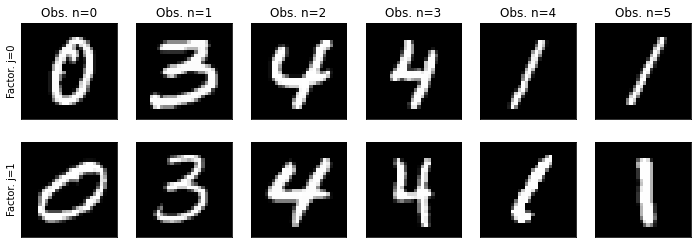

In [2]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(observations[facti][num_plot[obsi], :, :], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if facti == 0:
            plt.title('Obs. n=' + str(obsi))
        if obsi == 0:
            plt.ylabel('Factor. j=' + str(facti))

In [3]:
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

obs = [(obsi / obsi.max()).to(device).unsqueeze(1) for obsi in observations]

In [4]:
obs_locations = torch.linspace(0, 1, obs[0].shape[1]).unsqueeze(-1).to(device)

In [5]:
from recognition_parametrised_model import RPM
import torch.nn.functional as F

prior_params = {
    'gp_kernel': 'RBF',
    'scale': 1,
    'lengthscale': 0.01,
    'fit_kernel_scale': False,
    'fit_kernel_scale_prior': False,
    'fit_kernel_lengthscale': False,
    'fit_kernel_lengthscale_prior': False,
    'fit_prior_mean_param': False,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

factors_params = {
    'channels': [[1, 10, 20], [1, 10, 20]],
    'kernel_conv': [[5, 5], [5, 5]],
    'kernel_pool': [[2, 2], [2, 2]],
    'dim_hidden': [[50], [50]],
    'nonlinearity': [F.relu, F.relu],
    'covariance': ['fixed_diag', 'fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

auxiliary_params = {
    'channels': [[1, 10, 20], [1, 10, 20]],
    'kernel_conv': [[5, 5], [5, 5]],
    'kernel_pool': [[2, 2], [2, 2]],
    'dim_hidden': [[50], [50]],
    'nonlinearity': [F.relu, F.relu],
    'covariance': ['fixed_diag', 'fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

variational_params = {
    'inference_mode': 'amortized',  # 'amortized', 'parametrized'
    'channels': [[1, 10, 20], [1, 10, 20]],
    'kernel_conv': [[5, 5], [5, 5]],
    'kernel_pool': [[2, 2], [2, 2]],
    'dim_hidden': [[50], [50]],
    'dim_hidden_merged': [50],
    'nonlinearity': [F.relu, F.relu],
    'nonlinearity_merged': F.relu,
    'covariance': 'fixed_diag',
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

fit_params = {
    'num_epoch': 100,
    'batch_size': 2000,
    'dim_latent': 2,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
    'ergodic': False,
}

rpm = RPM(
    observations=obs,
    observation_locations=obs_locations,
    fit_params=fit_params,
)



RPM on GPU Observations on cuda:0


In [ ]:
rpm.fit(obs)

Epoch 1/100 Loss: 1.990003e+01
Epoch 2/100 Loss: 1.953746e+01
Epoch 3/100 Loss: 1.923879e+01
Epoch 4/100 Loss: 1.896651e+01
Epoch 5/100 Loss: 1.871677e+01
Epoch 6/100 Loss: 1.848771e+01
Epoch 7/100 Loss: 1.827739e+01
Epoch 8/100 Loss: 1.808399e+01
Epoch 9/100 Loss: 1.790570e+01
Epoch 10/100 Loss: 1.774096e+01
Epoch 11/100 Loss: 1.758838e+01
Epoch 12/100 Loss: 1.744674e+01
Epoch 13/100 Loss: 1.731498e+01
Epoch 14/100 Loss: 1.719217e+01
Epoch 15/100 Loss: 1.707748e+01
Epoch 16/100 Loss: 1.697018e+01
Epoch 17/100 Loss: 1.686963e+01
Epoch 18/100 Loss: 1.677525e+01
Epoch 19/100 Loss: 1.668655e+01
Epoch 20/100 Loss: 1.660305e+01
Epoch 21/100 Loss: 1.652435e+01
Epoch 22/100 Loss: 1.645008e+01
Epoch 23/100 Loss: 1.637990e+01
Epoch 24/100 Loss: 1.631350e+01
Epoch 25/100 Loss: 1.625061e+01
Epoch 26/100 Loss: 1.619094e+01
Epoch 27/100 Loss: 1.613422e+01
Epoch 28/100 Loss: 1.608011e+01


In [ ]:
from utils_process import plot_loss
plot_loss(rpm, offset=0)

In [ ]:
with torch.no_grad():
    rpm.num_observation_batch = obs[0].shape[0]
    rpm._update_variational(obs)
    rpm._update_marginals()
    mean, vari = [
        xx.detach().clone().cpu().numpy()
        for xx in rpm.dist_marginals.mean_covariance()
    ]

In [ ]:
obs[0].shape
obs[1].shape
#train_labels.shape

In [ ]:
labels2 = train_labels.reshape(observations[0].shape[0], num_factors)
labels2.shape

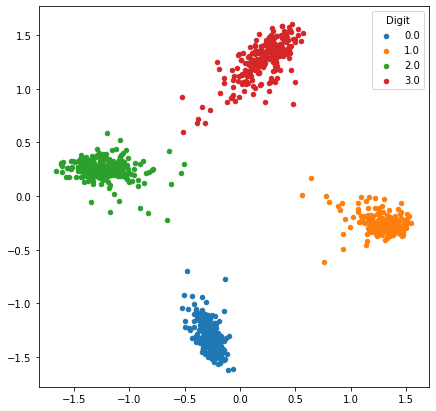

In [157]:
subset = 1000
xx = mean[:subset]
yy = labels2[:subset, 0].numpy()

plt.figure(figsize=(7, 7))
for ii in np.unique(yy):
    y0 = yy[np.where(yy == ii)]
    x0 = xx[np.where(yy == ii)]
    plt.scatter(x0[:, 0, 0], x0[:, 0, 1], s=20, label=str(ii))
    
plt.legend(title = 'Digit')